In [1]:
import math

import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from copy import deepcopy
import torch.nn
import torchvision.transforms as transforms
import torchvision
from NetworkWrapper import *
from Dataloader import *
import numpy as np
import math
import cv2
from torchsummary import summary
import time
import shutil
import os
import datetime

# Setting Up The Dataloader

In [2]:
# Mode corresponds to the directory within the data folder, test loads the test folder and train loads the train folder
# We define a pre_transformation of ToTensor (This transformation is applied as it loads out data)
# We can also define transform = None since we are not applying transformations such as random flipping which are needed to work
# as we load the batches.

# Summary.
# Pre_transform transforms all the data when we load the directory
# Transform transforms data when we load up batches for the network
train_set = ImageDataSet(mode="train",transform=None, pre_transform=transforms.ToTensor(), data_dir="Data")
val_set = ImageDataSet(mode="test",transform=None, pre_transform=transforms.ToTensor(), data_dir="Data")

Pre-Transforming Data
Finished Pre-Transforming.
Pre-Transforming Data
Finished Pre-Transforming.


# Showing Some Example Images

In [3]:
# dataset = torch.utils.data.DataLoader(train_set, batch_size=len(train_set))
#
# data, label = next(iter(dataset))
# mean_c1 = data[:, 0, :, :].mean()
# print(mean_c1)
# std_c1 = data[:, 0, :, :].mean()
#
#
# train_transform=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([mean_c1], std=[std_c1]),
#     transforms.RandomErasing(0.3),
#     transforms.RandomVerticalFlip(0.4),
#     transforms.RandomPerspective(0.4)
# ])
#
# train_set = ImageDataSet(mode="train",transform=train_transform, pre_transform=None, data_dir="Data")
#

In [4]:
# dataset = torch.utils.data.DataLoader(val_set, batch_size=len(val_set))
# data, label = next(iter(dataset))
# val_mean_c1 = data[:, 0, :, :].mean()
#
# print(val_mean_c1)
#
# val_std_c1 = data[:, 0, :, :].mean()
#
#
# val_transform=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([val_mean_c1], std=[val_std_c1])
# ])
#
# val_set = ImageDataSet(mode="test",transform=val_transform, pre_transform=None, data_dir="Data")

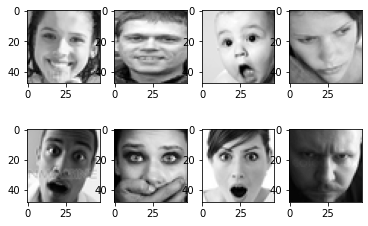

In [5]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
main_fig = plt.figure()
image_batch, labels = next(iter(trainloader))
for tmpC1 in range(8):
    img = np.moveaxis(image_batch[tmpC1].numpy(), 0, 2)
    plt.subplot(2, 4, tmpC1 + 1)
    plt.imshow(img/255.0, cmap="gray")


# Creating out network
Creating a network structure using nn.Sequential.
When we call the forward method, it goes through these one by one.

In [6]:
class Squeeze(nn.Module):
    def __init__(self):
        super(Squeeze, self).__init__()

        self.squeeze = torch.squeeze

    def forward(self, data):
        return self.squeeze(data)

deep_cnn = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=(3,3), padding=(1,1)),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=(3,3), padding=(1,1)),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Dropout(0.25),

    nn.Conv2d(64, 128, kernel_size=(5,5), padding=(2,2)),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.BatchNorm2d(128),
    nn.Dropout(0.25),

    nn.Conv2d(128, 512, kernel_size=(3,3), padding=(1,1)),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Dropout(0.25),

    nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1)),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Dropout(0.25),

    nn.AvgPool2d(kernel_size=(3,3)),
    Squeeze(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.25),

    nn.Linear(256, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.25),

    nn.Linear(512, 7),
)



# Printing the summary of our network
summary(deep_cnn.cuda(), (1, 48, 48))

# Defining the actual model to use our structure defined earlier
DeepCNN = NN(deep_cnn)

# Defining out optimiser and schedulers
optimiser = torch.optim.Adam(DeepCNN.parameters(), lr=0.0001, weight_decay=0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=5, gamma=0.5)

# Defining our network wrapper.
DefinedCNN = DefinedNN(DeepCNN,
                       n_classes=len(DefinedNN.classes()),
                       loss_function=nn.CrossEntropyLoss(),
                       optimiser=optimiser,
                       #lr_scheduler=lr_scheduler,
                       device="cuda:0",
                       )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
            Conv2d-3           [-1, 64, 48, 48]          18,496
              ReLU-4           [-1, 64, 48, 48]               0
       BatchNorm2d-5           [-1, 64, 48, 48]             128
         MaxPool2d-6           [-1, 64, 24, 24]               0
           Dropout-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]         204,928
              ReLU-9          [-1, 128, 24, 24]               0
      BatchNorm2d-10          [-1, 128, 24, 24]             256
        MaxPool2d-11          [-1, 128, 12, 12]               0
      BatchNorm2d-12          [-1, 128, 12, 12]             256
          Dropout-13          [-1, 128, 12, 12]               0
           Conv2d-14          [-1, 512,

# Starting Tensorboard
Specify output directory and then run the code below.
After, navigate to http://localhost:6006/

In [7]:
tensorboard_dir = 'runs/'

DefinedCNN.start_tensorboard(tensorboard_dir + "RAW_Test/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

DefinedCNN.add_image(torchvision.utils.make_grid(image_batch/255, nrow=4), "Example FER13 Data")

projector_image, projector_labels = train_set.__getitem__(list(torch.randint(low=0, high=len(train_set.labels)+1, size=(100,))))
projector_labels = [DefinedCNN.classes[label] for label in projector_labels]
DefinedCNN.add_embedding(mat=projector_image.view((-1, 48 * 48)),
                         metadata=projector_labels,
                         label_img=projector_image/255,
                         tag="RAW_Test_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

%load_ext tensorboard
%tensorboard --logdir={tensorboard_dir}  --host=localhost --reload_interval=30



time_start = time.time()
# Training it
DefinedCNN.train(train_set=train_set, val_set=val_set, max_epoch=60)
print(f"Took {time.time() - time_start}s to train")

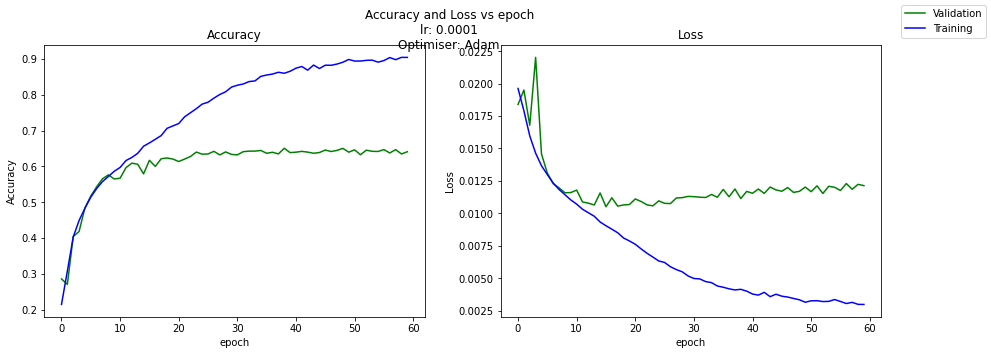

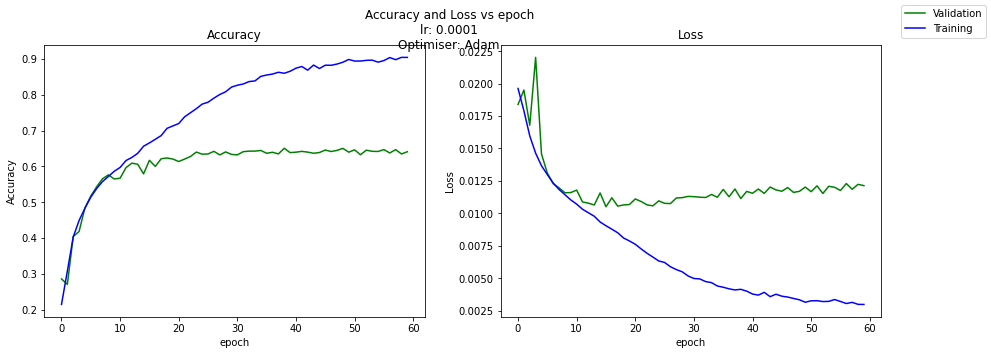

In [8]:
# Graphing statistics
DefinedCNN.graph()


# Loading a model
The network wrapper keeps track of all the parameters and scores during training. You can access these models by accessing the self.states variable.
The wrapper automatically extracts 3 of the best states for us, they are respectively called "val_loss", "train_loss", and "val_acc".

val_loss = model with lowest validation loss
train_loss = model with lowest training loss
val_acc = model with highest validation accuracy.

In [9]:
# Loading model with highest val acc
DefinedCNN.load_model("val_acc")

# Testing out newly loaded model with the val set to initialise necessary data.
sorted_pred = DefinedCNN.test_model(val_set)

0.650459738088604


# Confusion Matrix and Occlusion Sensitivity

## Confusion Matrix

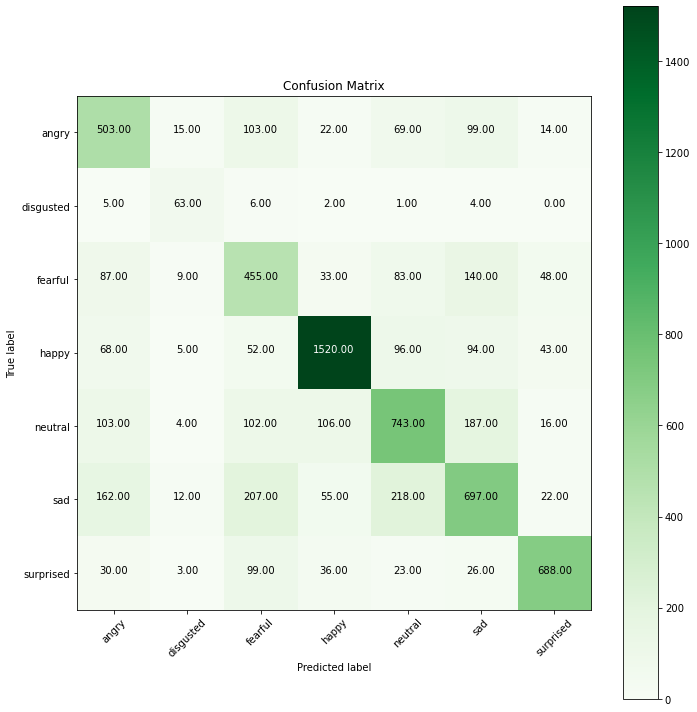

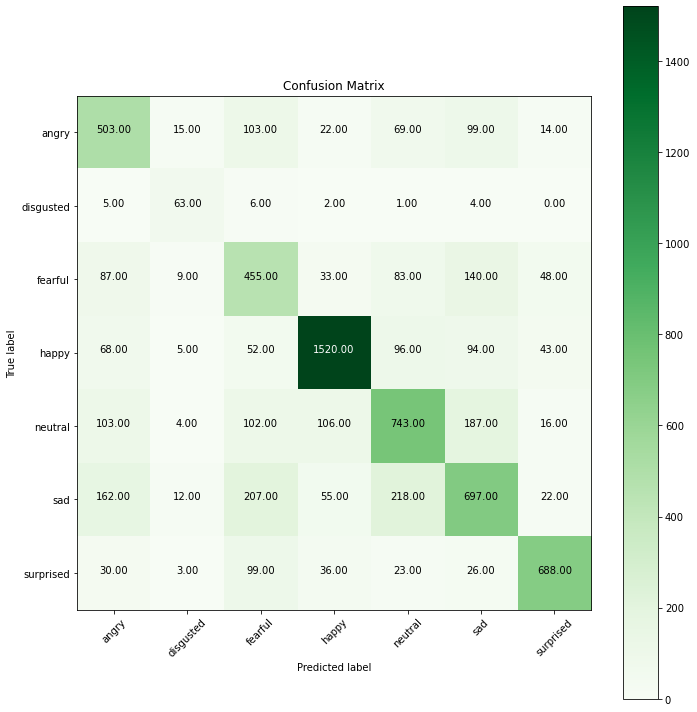

In [10]:
# Confusion matrix
DefinedCNN.visualise_confusion_matrix(plt.cm.Greens)

In [11]:
# Occlusion sensitivity

# Printing our classes, these are one of the only hard coded variables within the network wrapper.
classes = DefinedNN.classes()
classes_dic = DefinedNN.classes_dictionary()
print(classes)
print(classes_dic)



['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


## Occlusion Sensitivity

In [12]:
# Sorted predictions are sorted into classes (angry, sad, disgust etc), where each class has an array of True(ly) and False(ly) predicted images.
# Kernel size is the size of how big the kernel is that slides over the image to cover up the parts.
# Factor is the scaling to make the heat map for the occlusion sensitivity more red or more blue.
# figsize is figure size.

# Example below, I target the angry faces, and I target the most CORRECT accurately predicted angry face.
img = sorted_pred[DefinedCNN.classes_dictionary['angry']].get(True)[0]
fig1, fig2 = DefinedCNN.visualise_occlusion_sensitivity(img, kernel=(8,8), figsize=(10,10), factor=300, fontsize=10*1.5,cmap=plt.cm.coolwarm)


# Example below, I target the angry faces, and I target the most INCORRECT not accurately predicted angry face (With highest softmax score but was incorrectly predicted).
img = sorted_pred[DefinedCNN.classes_dictionary['angry']].get(False)[0]
fig1, fig2 = DefinedCNN.visualise_occlusion_sensitivity(img, kernel=(8,8), figsize=(10,10), factor=300, fontsize=10*1.5,cmap=plt.cm.coolwarm)


ValueError: expected 2D or 3D input (got 1D input)